In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

In [2]:
cols = ['test_acc',
        'train_time',
        'entropy__bal_acc', 
        'entropy__auc']

In [3]:
experiments = ['convolutional', 'convolutional-dropout', 'convolutional-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['inside', 'outside',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
final_results.columns

Index(['inside', 'outside', 'convolutional_in_test_acc',
       'convolutional-dropout_in_test_acc',
       'convolutional-poor-bayesian_in_test_acc', 'convolutional_out_test_acc',
       'convolutional-dropout_out_test_acc',
       'convolutional-poor-bayesian_out_test_acc',
       'convolutional_in_train_time', 'convolutional-dropout_in_train_time',
       'convolutional-poor-bayesian_in_train_time',
       'convolutional_out_train_time', 'convolutional-dropout_out_train_time',
       'convolutional-poor-bayesian_out_train_time',
       'convolutional_in_entropy_acc', 'convolutional-dropout_in_entropy_acc',
       'convolutional-poor-bayesian_in_entropy_acc',
       'convolutional_out_entropy_acc',
       'convolutional-dropout_out_entropy_acc',
       'convolutional-poor-bayesian_out_entropy_acc',
       'convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc',
       'convolutional-poor-bayesian_in_entropy_auc',
       'convolutional_out_entropy_auc',
       'convolut

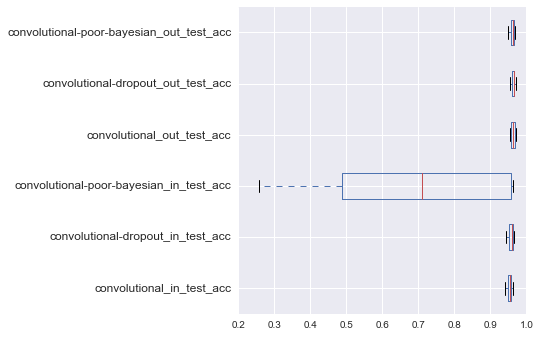

In [9]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 15)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[2:8])
plt.subplots_adjust(left=0.4)

In [10]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [11]:
out_acc = ['convolutional_out_entropy_auc', 'convolutional-dropout_out_entropy_auc', 'convolutional-poor-bayesian_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc', 'convolutional-poor-bayesian_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.98  1.2e-3   0.08   1.83   1.93   1.98   2.04   2.14   4000    1.0
theta_free[0]      0.29  1.7e-3   0.11   0.07   0.22   0.29   0.37   0.51   4000    1.0
theta_free[1]      0.46  1.7e-3   0.11   0.24   0.38   0.46   0.53   0.67   4000    1.0
sigma_likelihood    0.6  9.2e-4   0.06    0.5   0.56    0.6   0.64   0.73   4000    1.0
sigma_theta        1.79    0.06   3.73   0.23   0.47   0.79   1.66   9.52   4000    1.0
theta[0]           0.29  1.7e-3   0.11   0.07   0.22   0.29   0.37   0.51   4000    1.0
theta[1]           0.46  1.7e-3   0.11   0.24   0.38   0.46   0.53   0.67   4000    1.0
theta[2]          -0.75  1.8e-3   0.11  -0.96  -0.83  -0.75  -0.67  -0.53   4000    1.0
lp__              

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

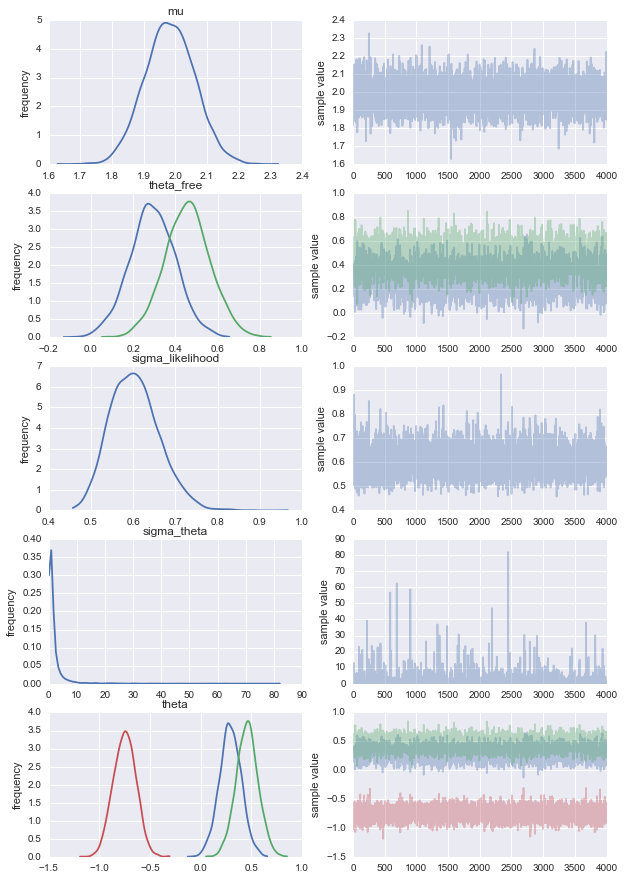

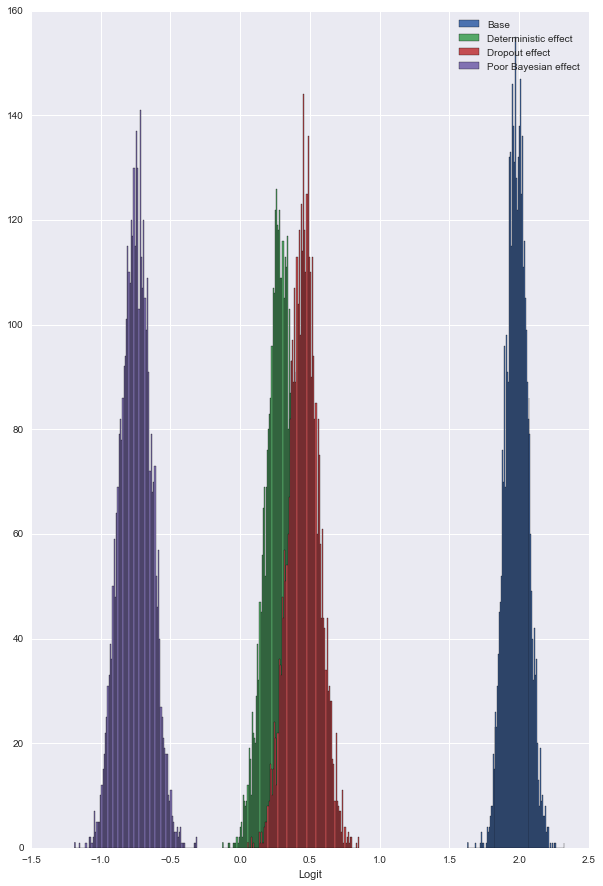

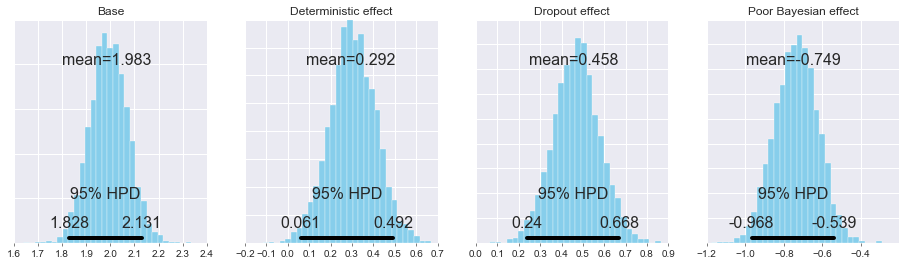

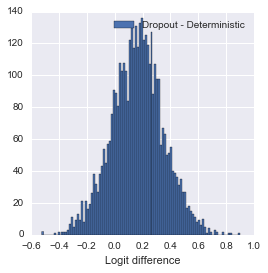

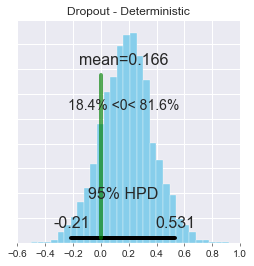

Dropout - Deterministic 95.0 CI: -0.209211494344 0.53264085919 Pr > 0: 0.8165


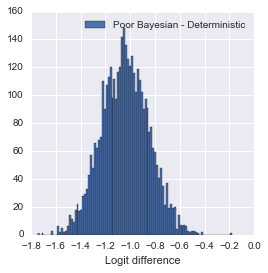

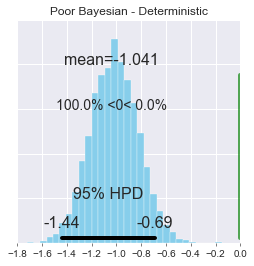

Poor Bayesian - Deterministic 95.0 CI: -1.41792039289 -0.664164892443 Pr > 0: 0.0


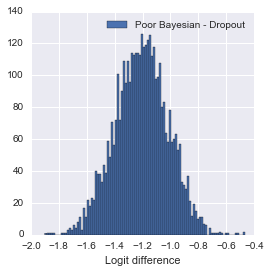

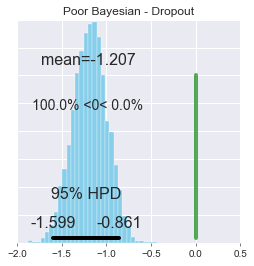

Poor Bayesian - Dropout 95.0 CI: -1.58303018084 -0.844356531392 Pr > 0: 0.0
Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.04  7.0e-4   0.04   1.95   2.02   2.05   2.07   2.13   4000    1.0
theta_free[0]     -0.09  9.9e-4   0.06  -0.21  -0.13  -0.09  -0.04   0.03   4000    1.0
theta_free[1]      0.18  1.1e-3   0.07   0.03   0.14   0.18   0.23   0.31   4000    1.0
sigma_likelihood   0.34  5.2e-4   0.03   0.28   0.31   0.34   0.36   0.41   4000    1.0
sigma_theta        0.71    0.03   1.62   0.05   0.16   0.29    0.6   3.95   4000    1.0
theta[0]          -0.09  9.9e-4   0.06  -0.21  -0.13  -0.09  -0.04   0.03   4000    1.0
theta[1]           0.18  1.1e-3   0.07   0.03   0.14   0.18   0.23   0.31   4000    1.0
theta[2]          -0.09  9.8e-

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

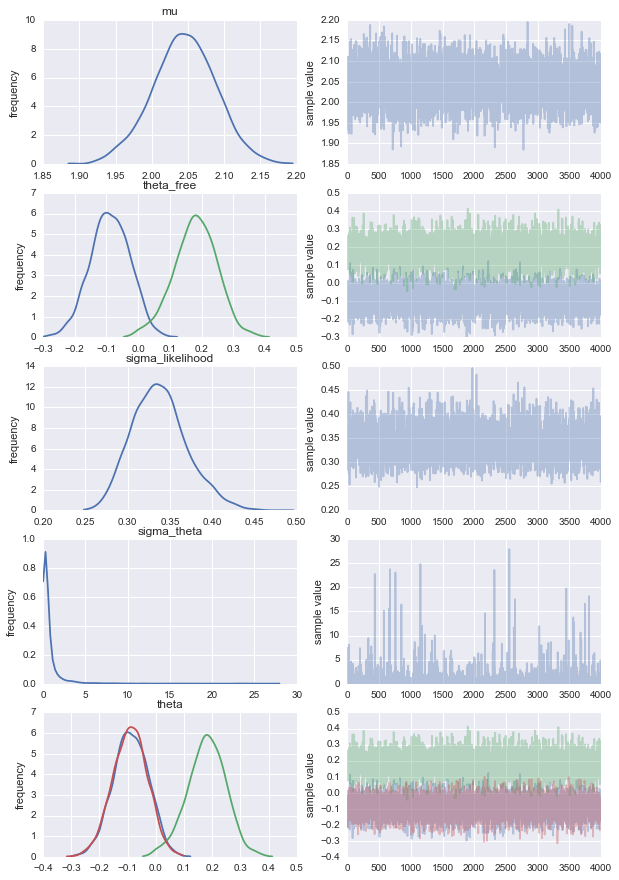

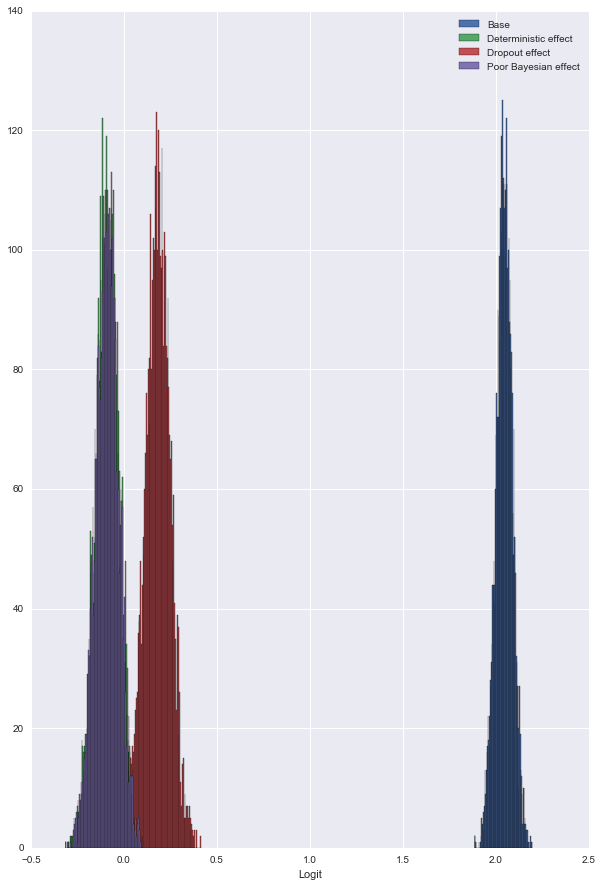

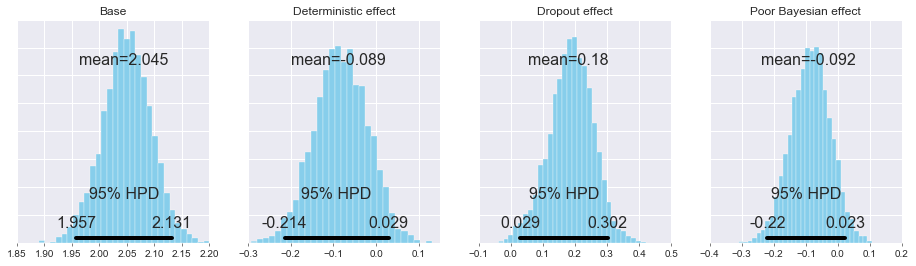

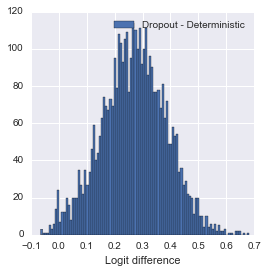

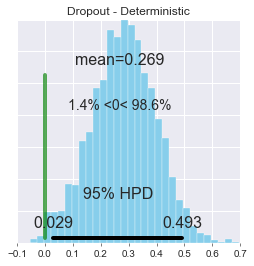

Dropout - Deterministic 95.0 CI: 0.0298415800225 0.493159118535 Pr > 0: 0.98625


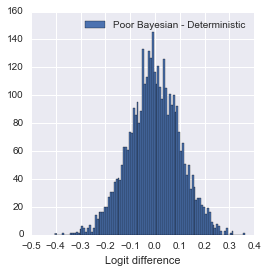

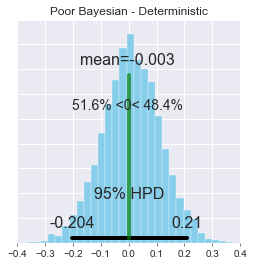

Poor Bayesian - Deterministic 95.0 CI: -0.212765235638 0.20173809006 Pr > 0: 0.48375


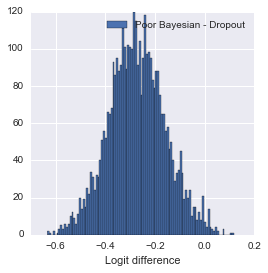

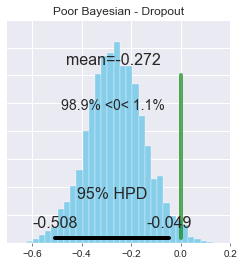

Poor Bayesian - Dropout 95.0 CI: -0.49895223363 -0.0364581387936 Pr > 0: 0.01075


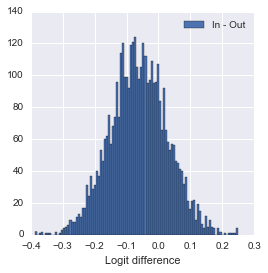

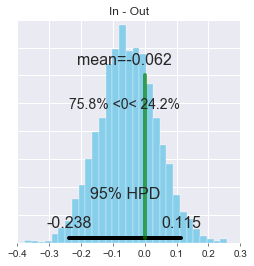

In - Out 95.0 CI: -0.23660497807 0.11736344031 Pr > 0: 0.242


In [12]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Base", "Deterministic effect", "Dropout effect", "Poor Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')